# Exploring Philly's Amenity Landscape

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import altair as alt
from sklearn.cluster import KMeans
import re
from wordcloud import WordCloud
echo: False


# Show all columns in dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

np.seterr(invalid="ignore");

In [2]:
# amenities

amenity_summed = gpd.read_file("data/amenities_grouped.csv")
amenity_point = gpd.read_file("data/amenities_phl_gdf.geojson")
amenity_neigh = gpd.read_file("data/amenities_neigh.geojson")

In [3]:
# boundaries 
phl_bound = gpd.read_file("data/Yelp API/phl_bound.geojson")
phl_neigh = gpd.read_file("https://raw.githubusercontent.com/opendataphilly/open-geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson")
phl_tract = gpd.read_file("data/Yelp API/census-tracts.geojson")
districts = gpd.read_file("data/Planning_Districts.geojson")

# reproject boundaries
phl_bound_proj = phl_bound.to_crs(2272)
phl_neigh_proj = phl_neigh.to_crs(2272)
phl_tract_proj = phl_tract.to_crs(2272)
districts_proj = districts.to_crs(2272)

## Amenity distributions

After cleaning our data from the Yelp Fusion API, we have a dataframe of 7579 total entries, with 6160 unique amenities. Some amenities were duplicated because of their multi-use and can be categorized as two or more amenities. These entries better reflect on the goods and services provided for the area. Yet this only accounts for roughly 20% of the data.

Below you can see every amenity identified in Philadelphia ranging from arts to shopping. We notice these are typically along major roadways or gathered around commerical corridors. The map allows users to explore all the different places Philadelphia has to offer. 

In [4]:
amenity_point["name"].nunique()

6160

Below are the point locations of the amenities we pulled from the API, colored by their category.

In [24]:
color_list = ['#88CCEE', '#CC6677', '#DDCC77', '#117733', '#332288', '#AA4499', '#44AA99', '#999933', '#882255', '#661100', '#6699CC', '#888888']


In [25]:
amenity_point.explore(tiles='CartoDB dark_matter', legend=True, column='type', cmap=color_list)

Following are the categories of the amenities, along with the count by type. The majority are restaurants, followed by beauty and grooming services, shopping, and nightlife.

In [6]:
amenity_summed["count"] = amenity_summed["count"].astype(int)
amenity_summed[["type", "count"]].sort_values("count", ascending = False)

type  count
10     restaurant   2632
1          beauty   1310
11       shopping    811
8       nightlife    694
2       education    504
3   entertainment    458
4         grocery    457
7            kids    326
0            arts    177
9           parks    147
6        historic     51
5      healthcare     12

With each category depicted separately, we can see distinct patterns in the locations of each type of amenity. Restaurants and beauty amenities lay in clusters spread throughout the city, while parks, arts, and nightlife are most concentrated in Center City. Historic landmarks, by contrast, are concentrated in the Old City area which houses a number of museums and historic sites. This map series helps define what each area has to offer depending on a newcomer or potential resident's priorities. 

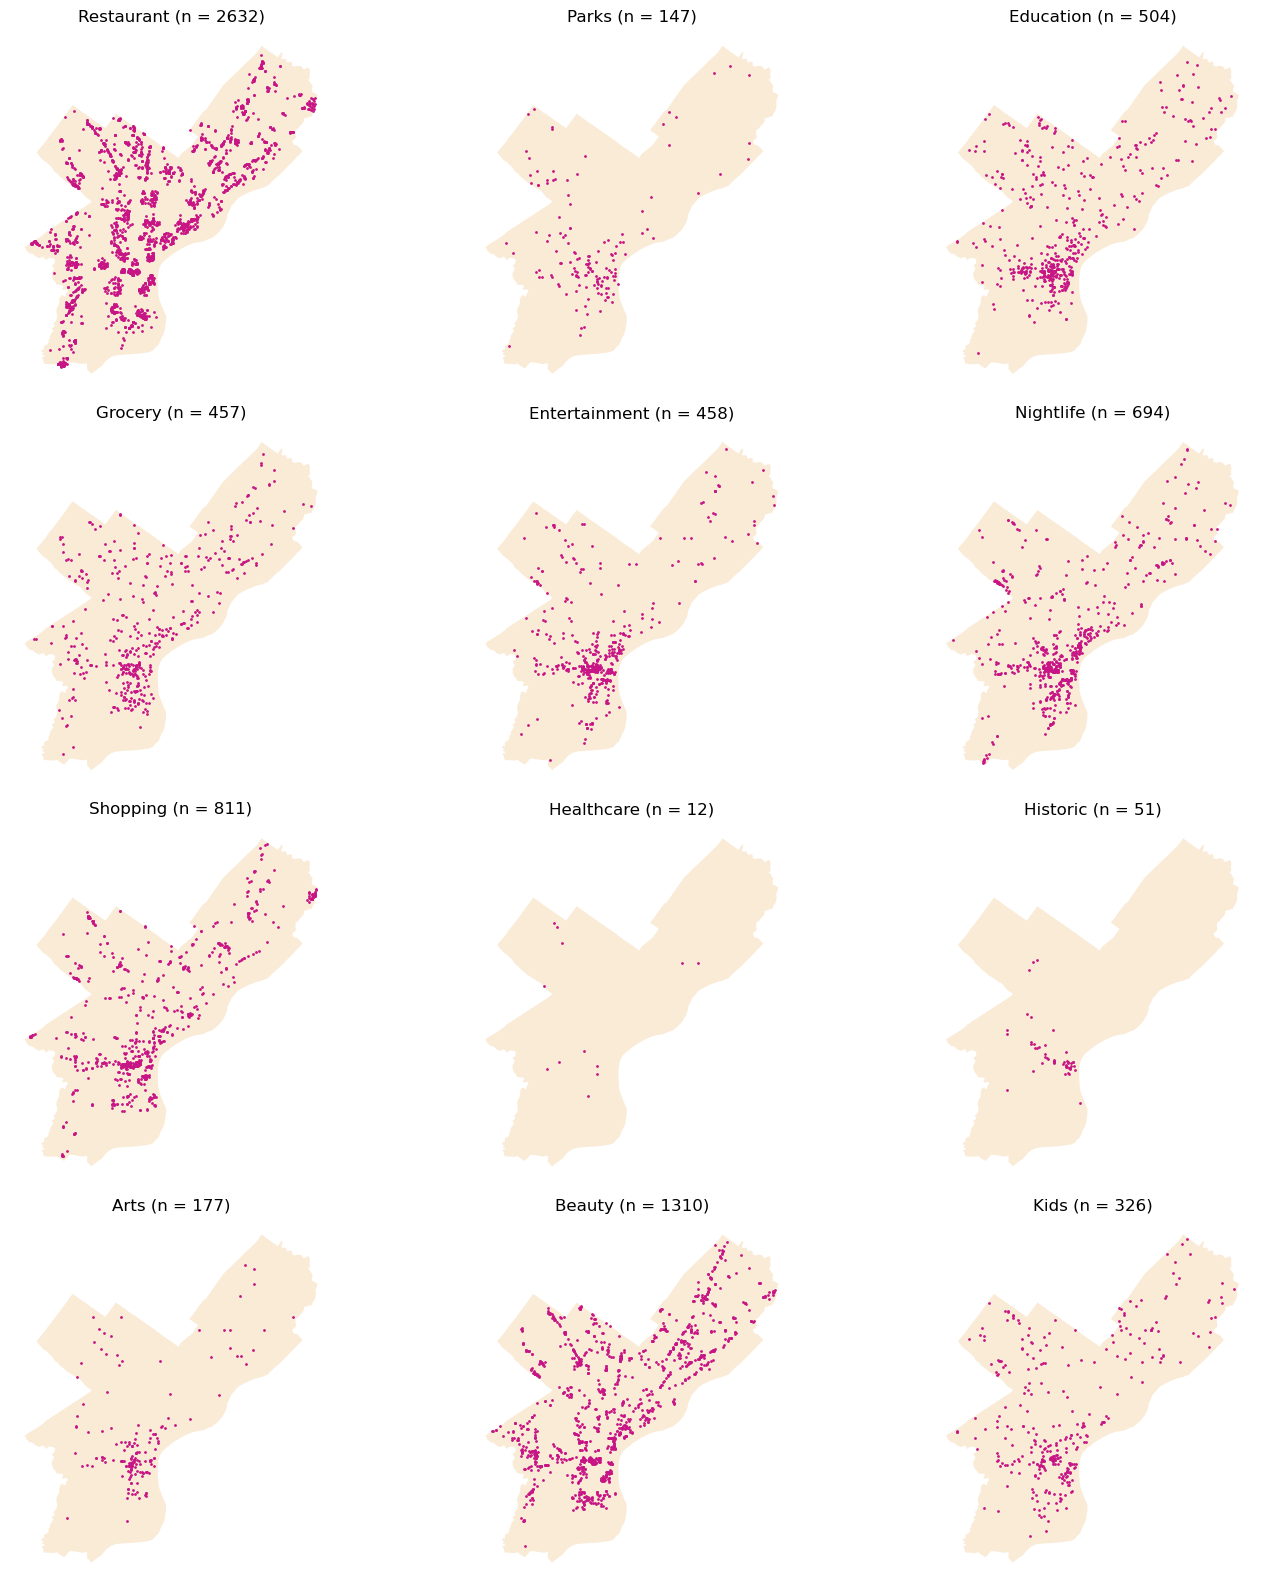

In [ ]:
# Extract unique business types
business_types = amenity_point['type'].unique()

# Determine the number of rows and columns for the subplots
n_rows = len(business_types) // 3 + (len(business_types) % 3 > 0)
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))

# Flatten the axes array for easy looping
axes = axes.flatten()

# Create a map for each business type
for i, business_type in enumerate(business_types):
    # Filter data for the current business type
    subset = amenity_point[amenity_point['type'] == business_type]

    # Get count for the current business type
    count = amenity_summed[amenity_summed['type'] == business_type]['count'].values[0]
    
    # phl boundary
    phl_bound_proj.plot(ax=axes[i], color='antiquewhite')
    
    # Plotting with transparency
    subset.plot(ax=axes[i], color='mediumvioletred', markersize=1, alpha=1)

    # Set title with count (n = count)
    axes[i].set_title(f"{business_type.capitalize()} (n = {count})")

    # Customizations: Remove boxes, axis ticks, and labels
    axes[i].set_axis_off()

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Display the panel of maps
plt.show()

## Percent share of amenity types

To control for neighborhoods that have higher counts of amenities in general, we also calculate the percentage share of each type of amenity in each neighborhood. This way, we can characterize the amenity profile of a neighborhood independent of the total number of amenities there. 

Looking at the share of each amenity type in each neighborhood, it appears that amenities such as grocery stores, beauty/grooming services, and restaurants make up a consistently high share of the amenities in neighborhoods across Philadelphia. By contrast, only select neighborhoods are dominated by nightlife, parks, arts, and other forms of entertainment.

Specific neighborhoods tend to excel at one particular amenity or feature. We notice University City has the highest share of educational institutions, nightlife is mostly in Center City, and the far northeast and northwest have a larger share of parks and kid-friendly features. 

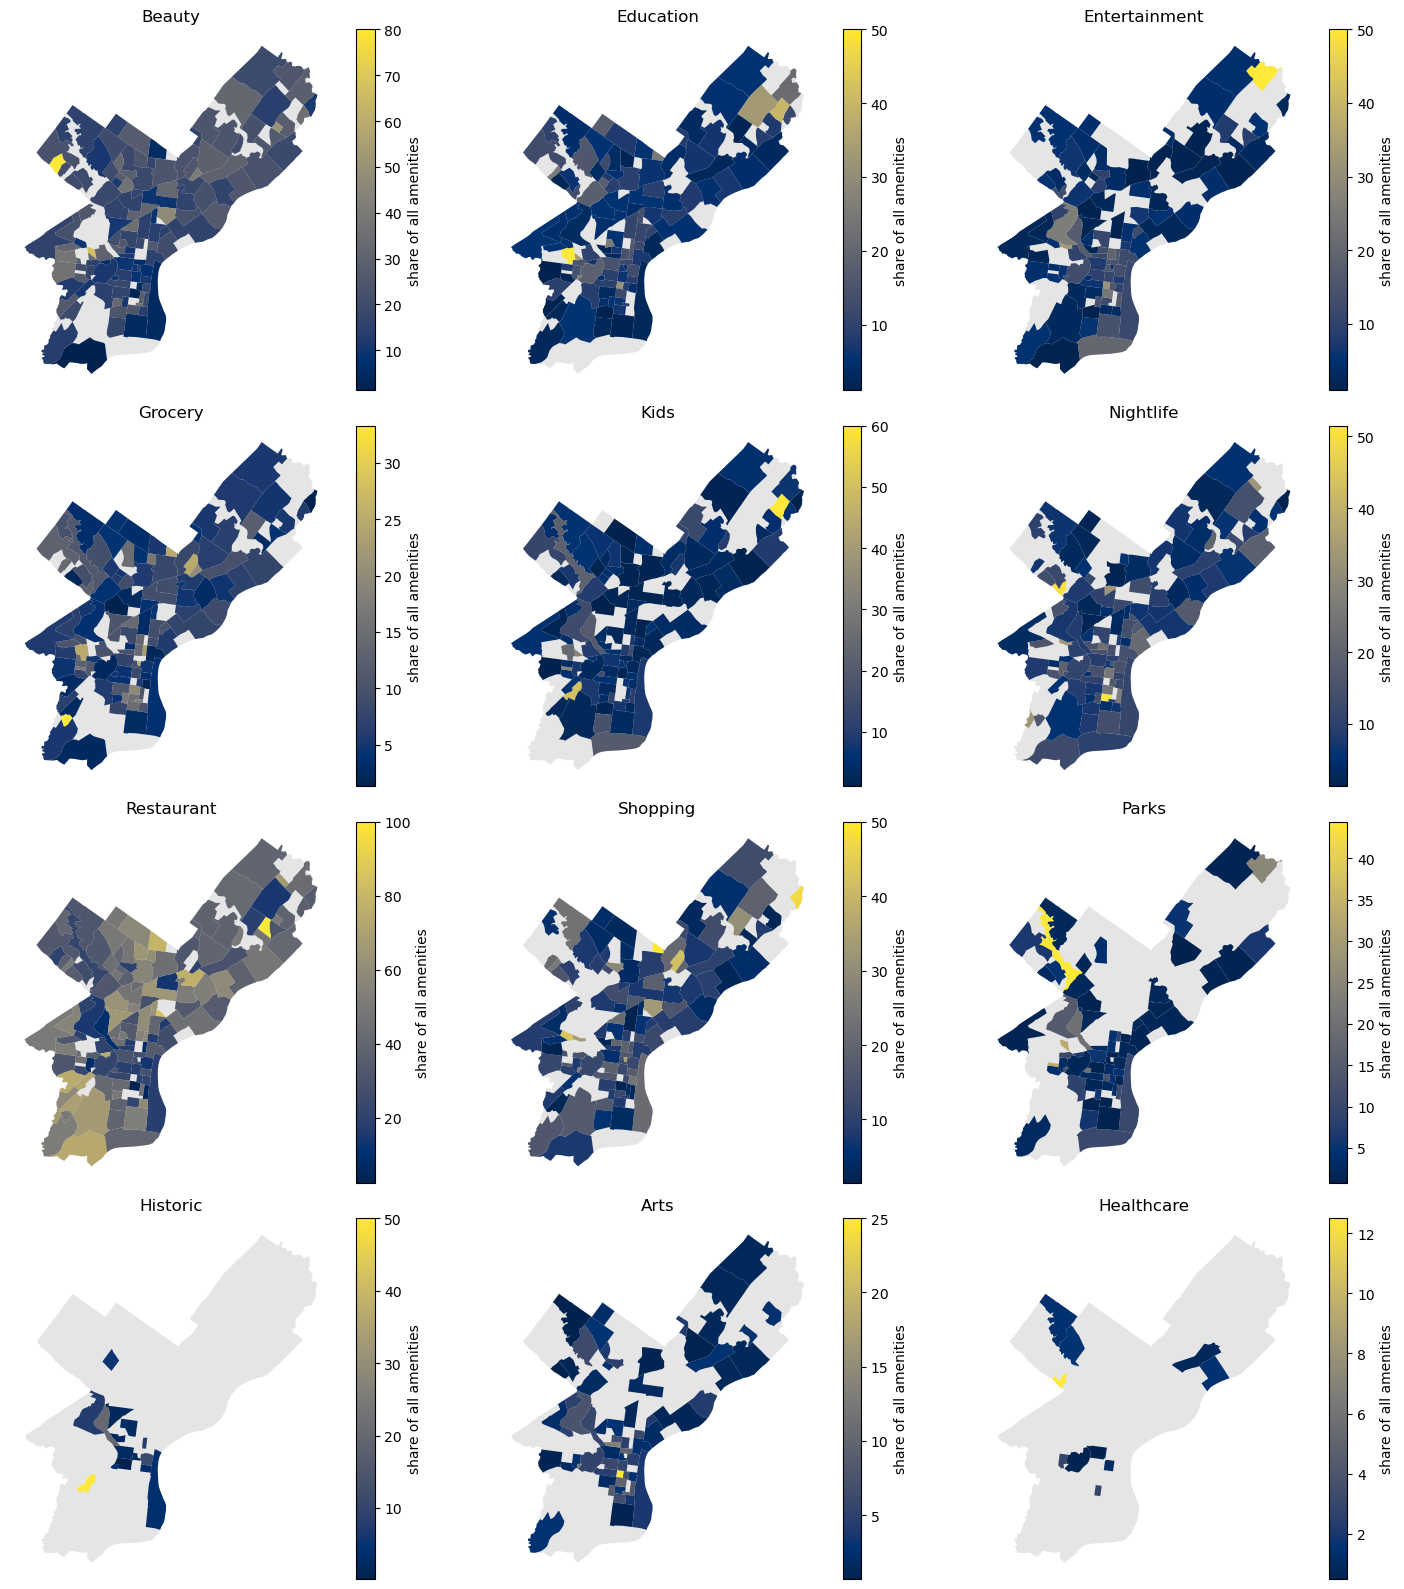

In [36]:
# Extract unique types
amenity_types = amenity_neigh['type'].unique()

# Determine the number of rows and columns for the subplots
n_rows = len(amenity_types) // 3 + (len(amenity_types) % 3 > 0)
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))

# Flatten the axes array for easy looping
axes = axes.flatten()

# Create a choropleth map for each amenity type
for i, amenity_type in enumerate(amenity_types):
    # Filter data for the current amenity type
    subset = amenity_neigh[amenity_neigh['type'] == amenity_type]
    
    # phl boundary
    phl_bound_proj.plot(ax=axes[i], color='gray', alpha = 0.2)
    

    # Plotting
    subset.plot(column='pct_share', ax=axes[i], legend=True,
                legend_kwds={'label': "share of all amenities"},
                cmap='cividis')

    # Set title
    axes[i].set_title(amenity_type.capitalize())
    
     # Remove boxes, axis ticks, and axis labels
    axes[i].set_axis_off()

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Display the panel of maps
plt.show()

## Word clouds: yelp listings

The text within the Yelp listings also has a lot of information about the composition of Philadelphia's amenity landscape. First, in a wordcloud of all the titles of the listings, we can see "pizza", "salon", "bar", "school", "studio", "restaurant", and "park" are featured prominently. 

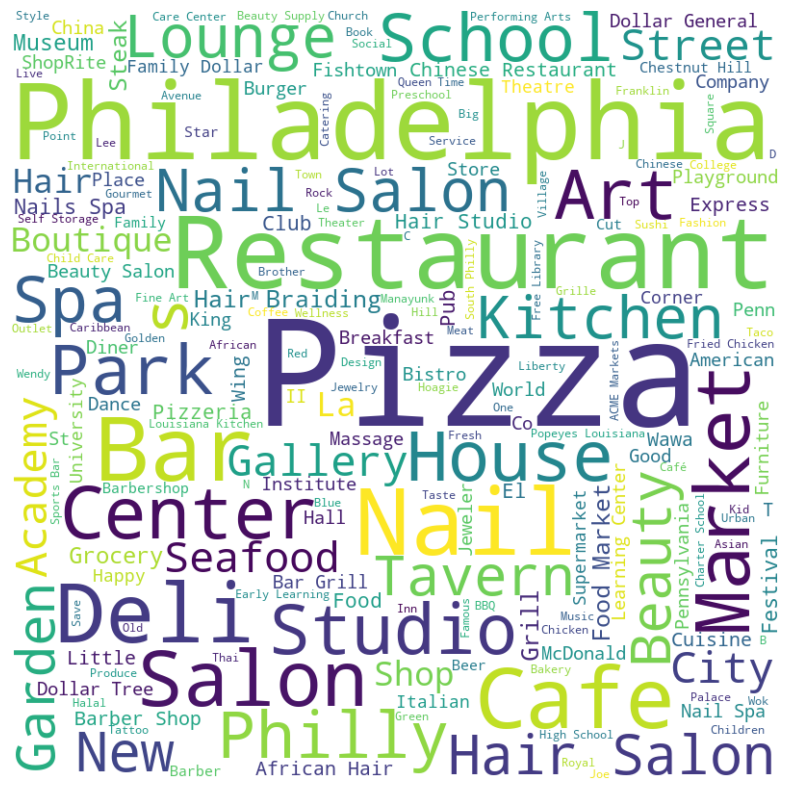

In [9]:
# Concatenate all text in the column
text = ' '.join(amenity_point["name"].dropna())

# Create the word cloud
wordcloud = WordCloud(width=800, height=800, background_color ='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Similarly, looking at the first word in yelp's "alias" field, we see that "bakeries", "cafes", "grocery", "theater", "sandwiches", and "delis" are some of the most prominent descriptions of amenity listings.

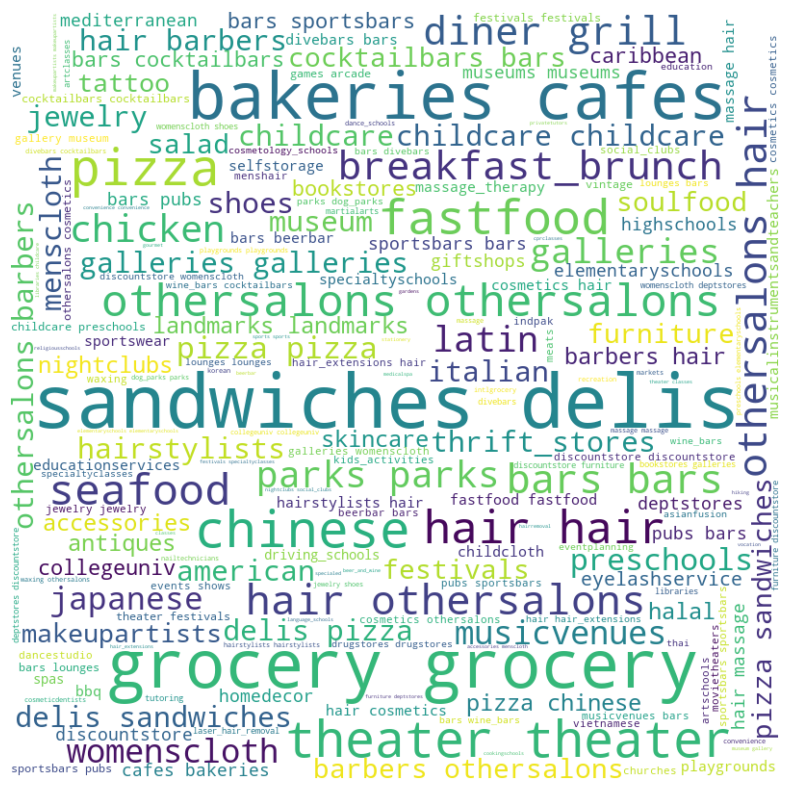

In [10]:
# Concatenate all text in the column
text = ' '.join(amenity_point["desc_1"].dropna())

# Create the word cloud
wordcloud = WordCloud(width=800, height=800, background_color ='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Amenity type correlations
Looking at the correlations between the neighborhoods that amenity types are found in, we see moderately strong correlations between the locations of entertainment and arts amenities (0.52), kids and historic amenities (0.47), and restaurants and entertainment (-0.5). Overall, there are no categories with correlations over 0.75, suggesting that our categories are distinct and experience different spatial processes.

In [11]:
# spreading the data
amenity_neigh_wide = amenity_neigh.pivot_table(index='nb_name', columns='type', values='pct_share', aggfunc=np.mean).fillna(0)

# Calculating the correlation matrix
correlation_matrix = amenity_neigh_wide.corr()

# Mask to remove upper triangular matrix (including the diagonal)
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

# Apply the mask to the correlation matrix
filtered_matrix = correlation_matrix.mask(mask)

# Reset index and melt for Altair
heatmap_data = filtered_matrix.reset_index().melt('type', var_name='type2', value_name='correlation').dropna()

# Create the heatmap
heatmap = alt.Chart(heatmap_data).mark_rect().encode(
    x='type:N',
    y='type2:N',
    color='correlation:Q'
)

# Add text to each cell
text = heatmap.mark_text(baseline='middle').encode(
    text=alt.Text('correlation:Q', format='.2f'),
    color=alt.condition(
        alt.datum.correlation > 0.4, 
        alt.value('white'),
        alt.value('black')
    )
)

# Display the chart
chart = (heatmap + text).properties(width=600, height=600)
chart

alt.LayerChart(...)